<a href="https://colab.research.google.com/github/infomon/understanding_cnn/blob/master/notebooks/Comparison_of_activation_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of activation functions
This notebooks compares different activations functions used in a simple 5-layer CNN for MNIST. For visualizing Integrated Gradients is used.

## Imports

In [1]:
!pip install -q git+https://github.com/albermax/innvestigate
!git clone https://github.com/infomon/understanding_cnn
import shutil
import os
if not os.path.isfile("utils.py"):
  shutil.move("/content/understanding_cnn/utils/utils.py", "/content")
if not os.path.isfile("utils_mnist.py"):
  shutil.move("/content/understanding_cnn/utils/utils_mnist.py", "/content")
!rm -r understanding_cnn

!git clone https://github.com/hiranumn/IntegratedGradients
if not os.path.isfile("IntegratedGradients.py"):
  shutil.move("/content/IntegratedGradients/IntegratedGradients.py", "/content")
!rm -r IntegratedGradients

Cloning into 'understanding_cnn'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 321 (delta 45), reused 14 (delta 5), pack-reused 221
Receiving objects: 100% (321/321), 38.83 MiB | 34.30 MiB/s, done.
Resolving deltas: 100% (148/148), done.
Cloning into 'IntegratedGradients'...
remote: Enumerating objects: 214, done.
remote: Total 214 (delta 0), reused 0 (delta 0), pack-reused 214
Receiving objects: 100% (214/214), 884.57 KiB | 21.57 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [0]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [3]:
%matplotlib inline  

import imp
import numpy as np
import os

import keras
import keras.backend
import keras.models
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint

import innvestigate
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "utils.py")
mnistutils = imp.load_source("utils_mnist", "utils_mnist.py")
IntegratedGradients = imp.load_source("IntegratedGradients", "IntegratedGradients.py")

from IntegratedGradients import *

Using TensorFlow backend.


## Data
Load the MNIST dataset for training and analysis

In [4]:
# Load data
# returns x_train, y_train, x_test, y_test as numpy.ndarray
data_not_preprocessed = mnistutils.fetch_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

x_train, y_train, x_test, y_test = data
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 1s 0us/step


In [5]:
# MNIST DATA
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../notebooks/MNIST_data/", one_hot=True)

X = np.expand_dims(mnist.train._images.reshape(55000,28, 28), 3)
Y = mnist.train._labels
X = np.expand_dims(mnist.test._images.reshape(10000,28, 28), 3)
Y = mnist.test._labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../notebooks/MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../notebooks/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../notebooks/MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../notebooks/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please u

## Models
Trains CNNs

In [0]:
activation_functions = ["relu","sigmoid","tanh"]

In [7]:
for activation_function in activation_functions:  
  batch_size = 128
  epochs = 15
  input_shape = (28, 28, 1)

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),
                  activation=activation_function,
                   input_shape=input_shape))
  model.add(Conv2D(64, (3, 3), activation=activation_function))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation=activation_function))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer='adam',
                metrics=['accuracy'])

  mcp_save = ModelCheckpoint('cnn_MNIST_'+activation_function+'_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

  model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            callbacks=[mcp_save],
            validation_data=(x_test, y_test))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 10s 167us/step - loss: 0.2720 - acc: 0.9169 - val_loss: 0.0513 - val_acc: 0.9834
Epoch 2/15
60000/60000 [==============================] - 4s 74us/step - loss: 0.0984 - acc: 0.9712 - val_loss: 0.0377 - val_acc: 0.9885
Epoch 3/15
60000/60000 [==============================] - 4s 74us/step - loss: 0.0714 - acc: 0.9781 - val_loss: 0.0331 - val_acc: 0.9889
Epoch 4/15
60000/60000 [==============================] - 4s 74us/step - loss: 0.0592 - acc: 0.9818 - val_loss: 0.0293 - val_acc: 0.9906
Epoch 5/15
60000/60000 [==============================] - 5s 79us/step - loss: 0.0519 - acc: 0.9838 - val_loss: 0.0299 - val_acc: 0.9913
Epoch 6/15
60000/60000 [====

In [8]:
from keras.layers import LeakyReLU

alpha = 0.3
batch_size = 128
epochs = 15
input_shape = (28, 28, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 input_shape=input_shape))
model.add(LeakyReLU(alpha))
model.add(Conv2D(64, (3, 3)))
model.add(LeakyReLU(alpha))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(LeakyReLU(alpha))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

mcp_save = ModelCheckpoint('cnn_MNIST_'+"LeakyReLU"+'_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[mcp_save],
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 6s 96us/step - loss: 0.2005 - acc: 0.9382 - val_loss: 0.0547 - val_acc: 0.9818
Epoch 2/15
60000/60000 [==============================] - 5s 86us/step - loss: 0.0777 - acc: 0.9764 - val_loss: 0.0482 - val_acc: 0.9855
Epoch 3/15
60000/60000 [==============================] - 5s 86us/step - loss: 0.0621 - acc: 0.9812 - val_loss: 0.0358 - val_acc: 0.9873
Epoch 4/15
60000/60000 [==============================] - 5s 86us/step - loss: 0.0513 - acc: 0.9842 - val_loss: 0.0417 - val_acc: 0.9869
Epoch 5/15
60000/60000 [==============================] - 5s 86us/step - loss: 0.0474 - acc: 0.9848 - val_loss: 0.0414 - val_acc: 0.9859
Epoch 6/15
60000/60000 [==============================] - 5s 86us/step - loss: 0.0424 - acc: 0.9863 - val_loss: 0.0404 - val_acc: 0.9874
Epoch 7/15
60000/60000 [==============================] - 5s 86us/step - loss: 0.0393 - acc: 0.9869 - val_loss: 0.0368 - val_acc

In [9]:
from keras.layers import PReLU

batch_size = 128
epochs = 15
input_shape = (28, 28, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 input_shape=input_shape))
model.add(PReLU())
model.add(Conv2D(64, (3, 3)))
model.add(PReLU())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128))
model.add(PReLU())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

mcp_save = ModelCheckpoint('cnn_MNIST_'+"PReLU"+'_model.hdf5', save_best_only=True, monitor='val_acc', mode='max')

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=[mcp_save],
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 8s 132us/step - loss: 0.2332 - acc: 0.9273 - val_loss: 0.0494 - val_acc: 0.9833
Epoch 2/15
60000/60000 [==============================] - 7s 120us/step - loss: 0.0732 - acc: 0.9779 - val_loss: 0.0362 - val_acc: 0.9866
Epoch 3/15
60000/60000 [==============================] - 7s 119us/step - loss: 0.0554 - acc: 0.9830 - val_loss: 0.0356 - val_acc: 0.9884
Epoch 4/15
60000/60000 [==============================] - 7s 120us/step - loss: 0.0467 - acc: 0.9853 - val_loss: 0.0288 - val_acc: 0.9900
Epoch 5/15
60000/60000 [==============================] - 7s 123us/step - loss: 0.0379 - acc: 0.9883 - val_loss: 0.0299 - val_acc: 0.9908
Epoch 6/15
60000/60000 [==============================] - 7s 121us/step - loss: 0.0354 - acc: 0.9895 - val_loss: 0.0313 - val_acc: 0.9893
Epoch 7/15
60000/60000 [==============================] - 7s 119us/step - loss: 0.0289 - acc: 0.9909 - val_loss: 0.0301 - 

## Analysis

In [0]:
model_file_names = ["cnn_MNIST_sigmoid_model.hdf5",
                    "cnn_MNIST_tanh_model.hdf5",
                    "cnn_MNIST_relu_model.hdf5",
                    "cnn_MNIST_LeakyReLU_model.hdf5",
                    "cnn_MNIST_PReLU_model.hdf5",
                   ]

In [19]:
n = 100
test_images = list(zip(X[:n], Y[:n]))

analysis = np.zeros([len(model_file_names),len(test_images),10,28,28,1])

for j,model_name in enumerate(model_file_names):
  print(model_name)
  model = load_model(model_name)
  model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
  
  ig = integrated_gradients(model)  
  
  for i, (x, y) in enumerate(test_images):
    # Add batch axis.
    #x = x[None, :, :, :]
    
    # Predict final activations, probabilites, and label.
    #presm = model_wo_softmax.predict_on_batch(x)[0]
    #prob = model.predict_on_batch(x)[0]
    #y_hat = prob.argmax()
    
    for k in range(0,10):
      analysis[j,i,k] = ig.explain(x,outc=k)

cnn_MNIST_sigmoid_model.hdf5
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
cnn_MNIST_tanh_model.hdf5
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
cnn_MNIST_relu_model.hdf5
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
cnn_MNIST_LeakyReLU_model.hdf5
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.
cnn_MNIST_PReLU_model.hdf5
Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


0 7


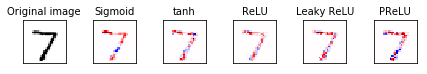

1 2


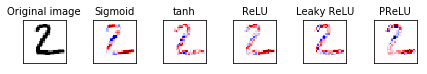

2 1


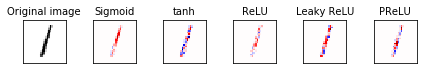

3 0


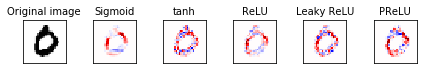

4 4


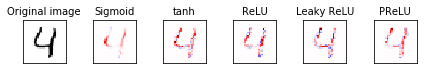

5 1


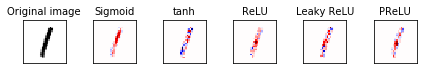

6 4


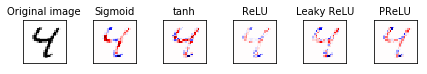

7 9


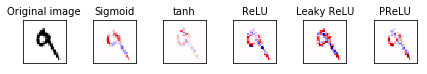

8 5


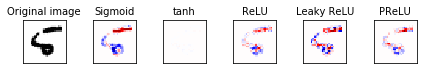

9 9


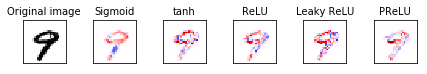

10 0


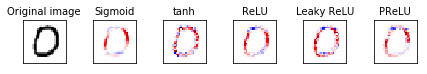

11 6


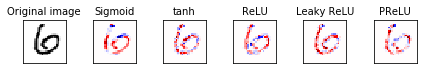

12 9


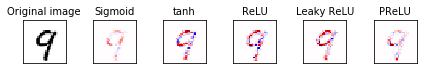

13 0


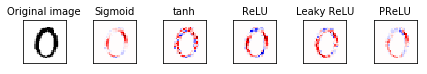

14 1


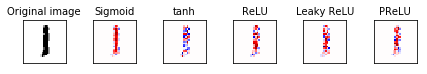

15 5


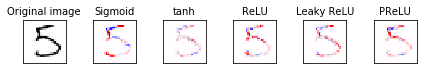

16 9


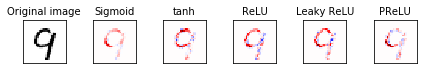

17 7


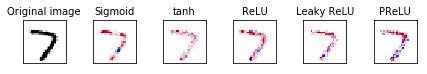

18 3


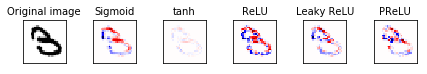

19 4


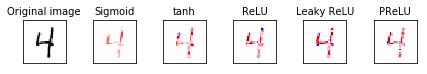

20 9


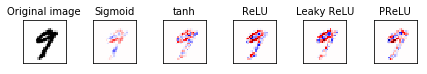

21 6


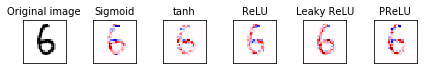

22 6


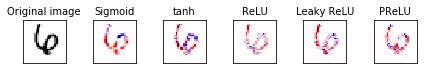

23 5


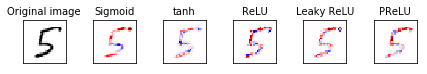

24 4


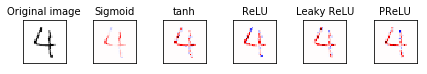

25 0


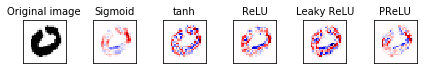

26 7


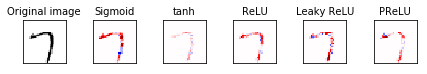

27 4


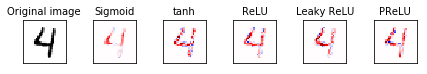

28 0


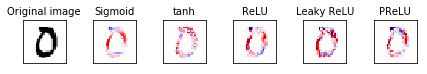

29 1


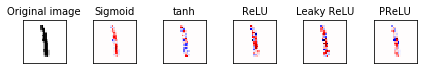

30 3


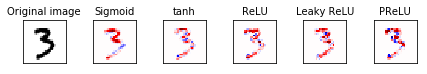

31 1


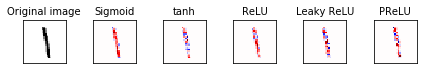

32 3


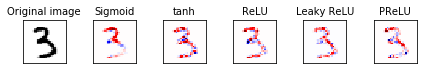

33 4


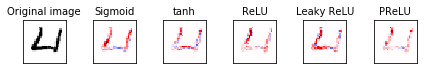

34 7


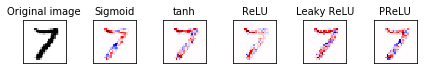

35 2


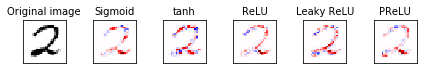

36 7


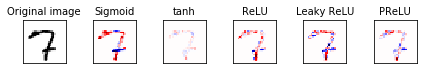

37 1


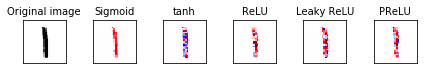

38 2


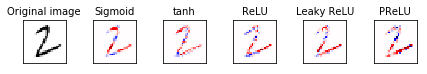

39 1


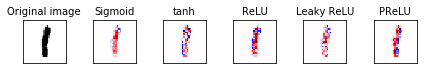

40 1


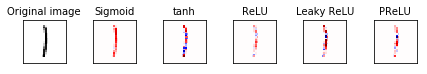

41 7


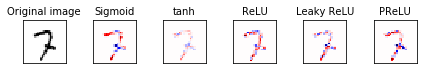

42 4


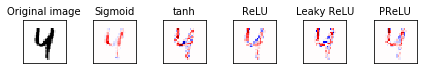

43 2


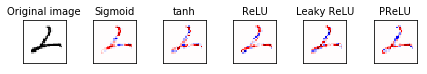

44 3


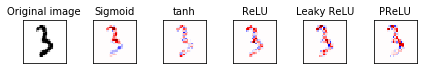

45 5


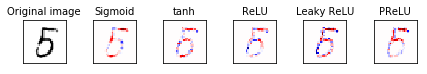

46 1


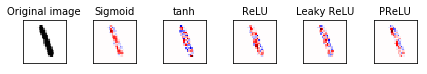

47 2


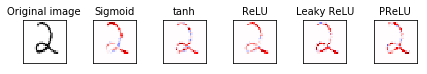

48 4


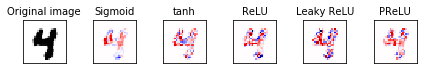

49 4


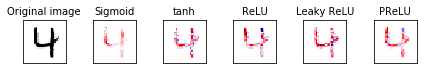

50 6


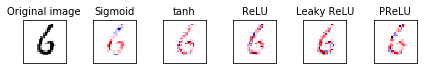

51 3


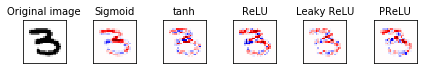

52 5


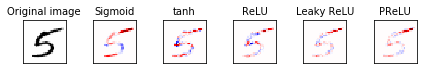

53 5


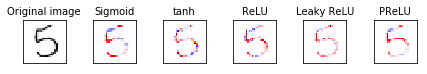

54 6


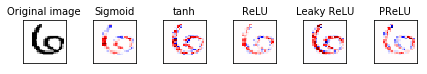

55 0


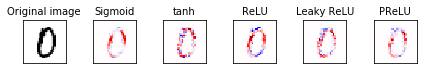

56 4


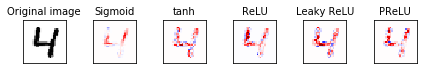

57 1


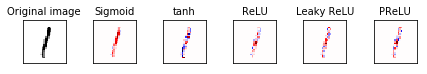

58 9


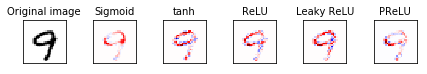

59 5


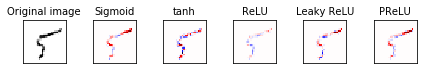

60 7


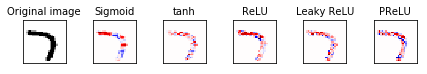

61 8


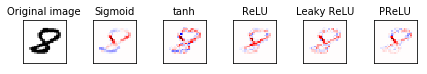

62 9


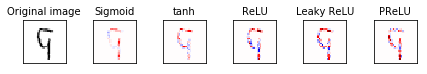

63 3


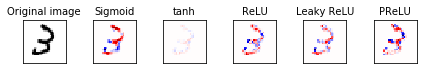

64 7


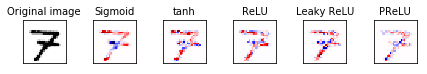

65 4


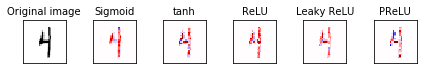

66 6


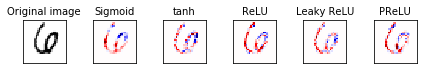

67 4


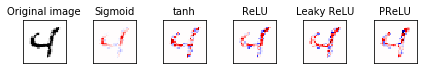

68 3


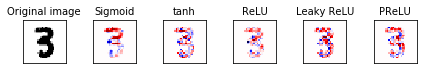

69 0


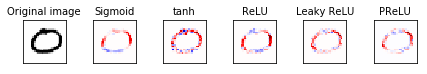

70 7


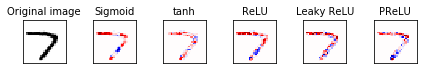

71 0


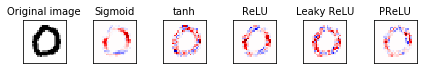

72 2


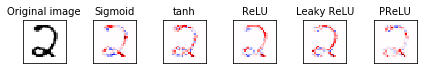

73 9


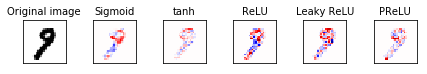

74 1


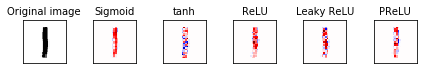

75 7


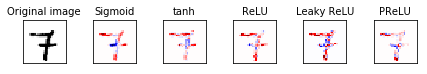

76 3


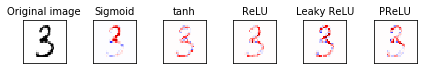

77 2


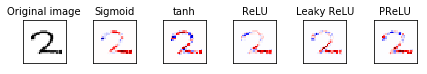

78 9


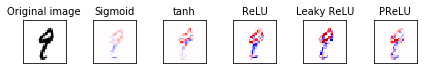

79 7


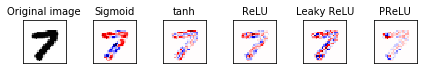

80 7


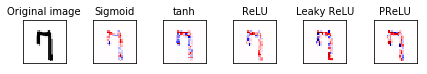

81 6


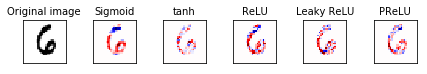

82 2


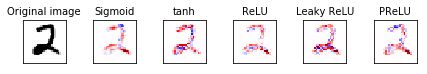

83 7


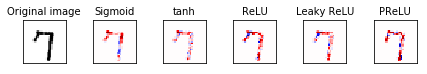

84 8


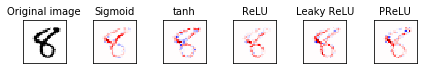

85 4


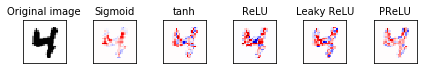

86 7


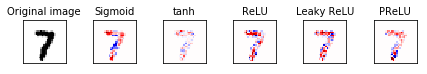

87 3


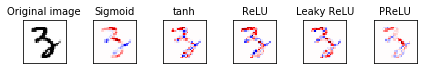

88 6


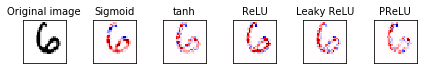

89 1


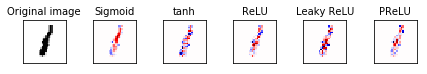

90 3


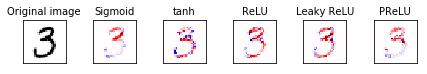

91 6


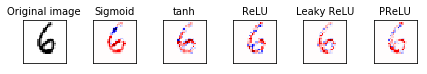

92 9


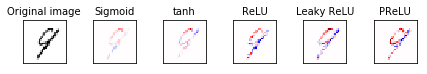

93 3


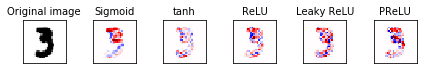

94 1


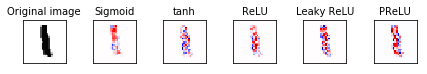

95 4


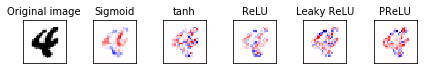

96 1


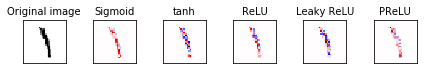

97 7


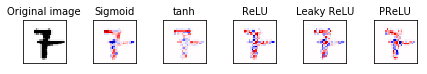

98 6


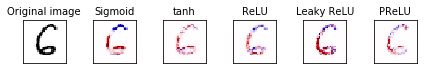

99 9


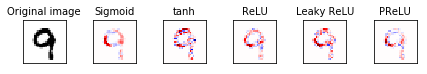

In [32]:
import matplotlib.pyplot as plt

model_names = ["Sigmoid", "tanh", "ReLU", 
               "Leaky ReLU", "PReLU"
              ]

for j in range(len(test_images)):
  print(j,np.argmax(test_images[j][1]))
  # Plot the true image.
  plt.figure()
  plt.subplot(1,6,1)
  plt.imshow(test_images[j][0].reshape((28,28)), cmap="Greys")
  plt.xticks([],[])
  plt.yticks([],[])
  plt.title("Original image", fontsize=10)

  for a in range(len(model_names)):
    # Generate explanation with respect to each of 10 output channels.
    exs = analysis[a,j,:,:,:,:]

    # Plot them
    th = max(np.abs(np.min(exs)), np.abs(np.max(exs)))
    plt.subplot(1,6,a+2)
    plt.imshow(exs[np.argmax(test_images[j][1])].reshape((28,28)), cmap="seismic", vmin=-1*th, vmax=th)
    #plt.imshow(exs[7].reshape((28,28)), cmap="seismic", vmin=-1*th, vmax=th)
    plt.xticks([],[])
    plt.yticks([],[])
    plt.title(model_names[a], fontsize=10)
  plt.tight_layout()
  #plt.savefig("../notebooks/figures/"+str(index)+".png")
  plt.show()